In [1]:
import json
import pandas as pd
from nltk import FreqDist
import matplotlib.pyplot as plt
from file_utils import read_from_pickle

## Data loading

In [2]:
df = pd.read_pickle('./text/vaccination_tweets.pkl')

## Transformation and prediction

In [3]:
MODEL_DIR = './models/vaccination_tweets'
TRAINING_SIZE_PCT = 'full'

transformer = read_from_pickle('{}/tfidf_transformer.pkl'.format(MODEL_DIR))
kmeans = read_from_pickle('{}/kmeans-{}.pkl'.format(MODEL_DIR, TRAINING_SIZE_PCT))

In [4]:
transformer

Pipeline(steps=[('count',
                 CountVectorizer(lowercase=False, max_df=0.3,
                                 min_df=0.00018315018315018315,
                                 token_pattern='\\S+')),
                ('tfid', TfidfTransformer())])

In [5]:
kmeans

KMeans(n_clusters=3, n_init=1, random_state=42, tol=5e-06)

In [6]:
corpus = df['tokens'].map(lambda x: ' '.join(x))
X = transformer.transform(corpus).toarray()
df['clusterN'] = kmeans.predict(X)
# remove from memory
corpus = None
X = None

In [7]:
df.head(3)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,tokens,clusterN
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,"[folk, said, daikon, paste, could, treat, cyto...",2
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,"[world, wrong, side, history, year, hopefully,...",2
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,Russian vaccine is created to last 2-4 y...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,"[russian, vaccine, created, last, 2-4, year]",2


## Top words per cluster

In [8]:
top_words_per_cluster = {}
clusters_n = df['clusterN'].unique()
for i in clusters_n:
    tokens = df[df['clusterN'] == i]['tokens'].explode()
    tokens = [token for token in tokens.to_list() if token in transformer[0].vocabulary_]
    fd = FreqDist(tokens)
    top_words_per_cluster[str(i)] = fd.most_common(10)
json.dumps(top_words_per_cluster)

'{"2": [["covid-19", 790], ["pfizer", 719], ["first", 618], ["today", 594], ["dos", 476], ["shot", 475], ["covid", 446], ["vaccination", 426], ["people", 404], ["one", 361]], "0": [["dose", 1227], ["first", 566], ["second", 342], ["today", 238], ["done", 232], ["2nd", 224], ["1st", 180], ["received", 169], ["pfizer", 119], ["covid-19", 93]], "1": [["vaccinated", 296], ["fully", 153], ["today", 30], ["dose", 24], ["covid-19", 20], ["second", 19], ["thank", 16], ["thanks", 10], ["finally", 10], ["first", 9]]}'

## Cluster description generation
- see gpt-cluster-name.prompt.txt file

In [9]:
# generated by OpenAI gpt4 model
cluster_names = {
  "2": "Vaccine Updates",
  "0": "Dose Progress",
  "1": "Fully Vaccinated Celebrations"
}

## Top Words Frequency per Cluster 

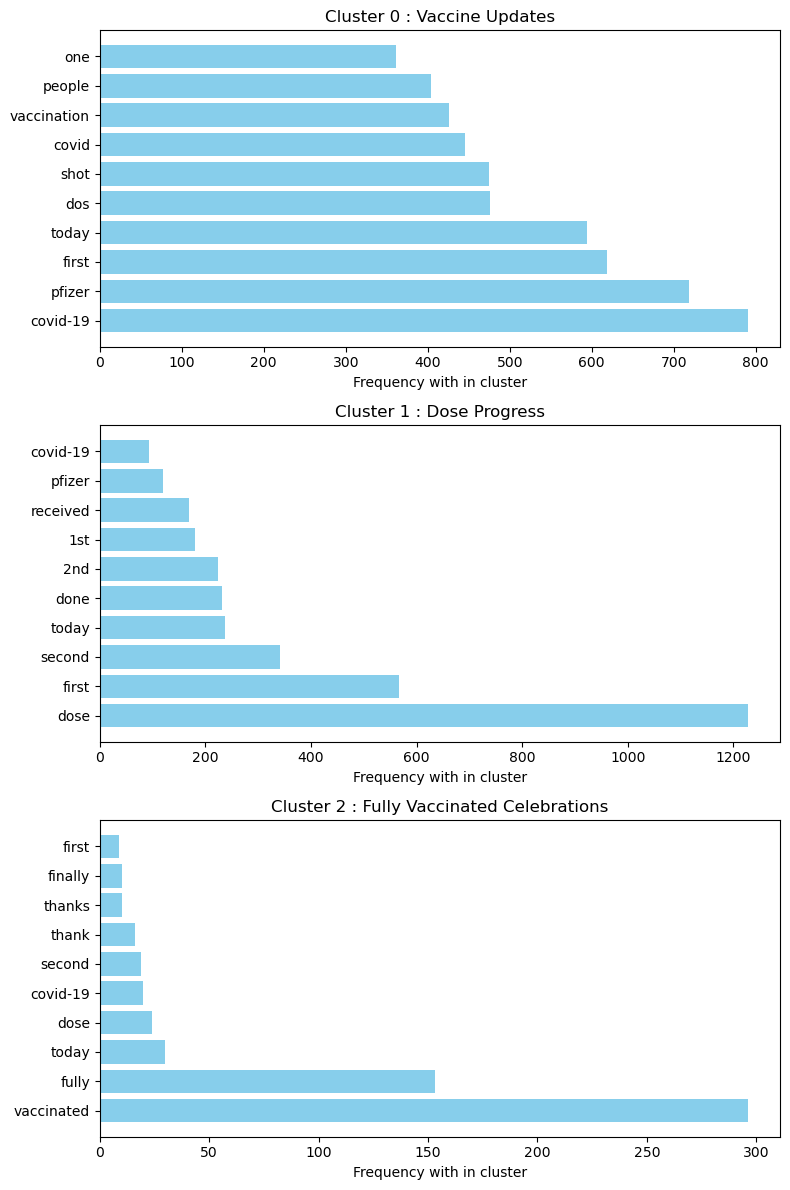

In [10]:
fig, axs = plt.subplots(nrows=len(clusters_n), figsize=(8, 4 * len(clusters_n)))
for i, (cluster, word_freq) in enumerate(top_words_per_cluster.items()):
    words, frequencies = zip(*word_freq)
    axs[i].barh(y=words, width=frequencies, color='skyblue')
    axs[i].set_title('Cluster {} : {}'.format(i, cluster_names[str(cluster)]))
    axs[i].set_xlabel('Frequency with in cluster')

plt.tight_layout()
plt.show()